# **Transformers for Text Classification**

Transformers have revolutionized Natural Language Processing (NLP) by enabling models to capture long-range dependencies, contextual relationships, and nuanced meanings in text.
In this notebook, we will build a Transformer-based text classification pipeline to automatically categorize news articles into relevant topics.


- Tokenization, vocabulary building, and embeddings work in PyTorch.
- Explore positional encoding and self-attention in depth.
- Implement and train a Transformer encoder for classification tasks.
- Visualize embeddings and attention patterns to understand the model’s inner workings.

### Installing required libraries


In [6]:
# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1
# !pip install pyarrow

### Importing required libraries


In [130]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import pickle

### Helper Functions


In [8]:
def plot(COST, ACC):
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

    plt.show()

In [9]:
def plot_embeddings(embeddings, labels, vocab) -> None:
    """
    Plots 3D embeddings with labels.

    Args:
        embeddings (np.ndarray): Array of shape (N, 3) containing 3D embeddings.
        labels (list[str]): List of token strings corresponding to embeddings.
        vocab: Vocabulary object with method get_stoi() returning token-to-index dict.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of embeddings
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], s=50, alpha=0.7)

    stoi = vocab.get_stoi()

    # Annotate each point with its label if present in vocab
    for idx, label in enumerate(labels):
        if label in stoi:
            x, y, z = embeddings[idx]
            ax.text(x, y, z, label, fontsize=9)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Embeddings Visualization')

    plt.tight_layout()
    plt.show()

In [109]:
def plot_embeddings_with_tsne(embeddings, tokens, title="Embeddings"):
    """
    Helper function to visualize high-dimensional embeddings in 2D using t-SNE.
    """
    tsne_model = TSNE(n_components=2, random_state=0, perplexity=min(2, len(tokens) - 1))

    # The input embeddings have shape [seq_len, d_model] -> [4, 100]
    # t-SNE reduces this to [seq_len, 2] -> [4, 2]
    tsne_result = tsne_model.fit_transform(embeddings.cpu().detach().numpy())

    # a scatter plot of the t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.title(title)

    # Add word labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        plt.text(tsne_result[j, 0] + 0.1, tsne_result[j, 1] + 0.1, label)

    plt.show()

### The `visualize_attention_mechanism` Function
This function's goal is to peek inside the first self-attention layer of the Transformer, visualize the attention scores, and see how the word embeddings are transformed.

In [110]:
def visualize_attention_mechanism(words, model, embed_dim=256):
    """
    Visualizes the self-attention mechanism of a Transformer model for a given input.
    Let's assume seq_len = number of words in the input string.
    """
    # Tokenize the input words using a tokenizer function
    # words = "I love machine learning", tokens = ['i', 'love', 'machine', 'learning']
    # seq_len = 4
    tokens = tokenizer(words)
    
    # model's embedding dimension (d_model)
    d_model = embed_dim

    # --- Input Preparation ---
    # Convert the input words to a PyTorch tensor and move it to the specified device
    # text_pipeline(words) -> [seq_len],  .unsqueeze(0) adds a batch dimension
    # SHAPE of x: [batch_size, seq_len] -> [1, 4]
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # --- Embedding and Positional Encoding ---
    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    # model.emb(x) maps token IDs to dense vectors.
    # SHAPE of x_: [batch_size, seq_len, d_model] -> [1, 4, 100]
    x_ = model.emb(x) * math.sqrt(d_model)

    # SHAPE of x: [batch_size, seq_len, d_model] -> [1, 4, 100]
    x = model.pos_encoder(x_)

    # --- Manual Self-Attention Calculation ---
    # Extract projection weights for query, key, and value from the model's state_dict.
    # PyTorch's MultiheadAttention fuses Wq, Wk, Wv into one large matrix for efficiency.
    # The shape of this fused matrix is [3 * d_model, d_model].
    # We are now splitting it back into the conceptual Wq, Wk, Wv.
    # Each slice has shape [d_model, d_model], and we transpose it to [d_model, d_model]
    # SHAPE of q_proj_weight, k_proj_weight, v_proj_weight: [d_model, d_model] -> [100, 100]
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim, :].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim, :].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim, :].t()

    # Calculate query (Q), key (K), and value (V) matrices by projecting the input.
    # (x @ weight) -> [1, seq_len, d_model] @ [d_model, d_model] = [1, seq_len, d_model]
    # .squeeze(0) removes the batch dimension.
    # SHAPE of Q, K, V: [seq_len, d_model] -> [4, 100]
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate raw attention scores using dot-product attention.
    # Q @ K.T -> [seq_len, d_model] @ [d_model, seq_len] = [seq_len, seq_len]
    # SHAPE of scores: [seq_len, seq_len] -> [4, 4]
    scores = Q @ K.T

    # --- Visualization of Attention Scores ---
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the raw, unnormalized attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Raw Dot-Product Attention Scores")
    plt.show()

    # Apply softmax to the attention scores to get probabilities. Shape does not change.
    # SHAPE of att: [seq_len, seq_len] -> [4, 4]
    att = nn.Softmax(dim=1)(scores)

    # Create a heatmap of the normalized attention probabilities
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Normalized Attention Probabilities (Softmax)")
    plt.show()

    # --- Attention Head Output ---
    # Calculate the attention head output by taking a weighted sum of Value vectors.
    # att @ V -> [seq_len, seq_len] @ [seq_len, d_model] = [seq_len, d_model]
    # SHAPE of head: [seq_len, d_model] -> e.g., [4, 100]
    head = att @ V

    # --- Visualization of Embeddings ---
    # Visualize the original embeddings and the attention-modified embeddings.
    plot_embeddings_with_tsne(x_.squeeze(0), tokens, title="Original Embeddings (before Positional Encoding)")
    plot_embeddings_with_tsne(x.squeeze(0), tokens, title="Original Embeddings (after Positional Encoding)")
    plot_embeddings_with_tsne(head, tokens, title="Attention Head Output Embeddings")

In [12]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

## Toy dataset
Defines a dataset, tokenizes the text data using a basic English tokenizer, creates a vocabulary from the tokenized data, and sets up a default index for handling unknown tokens.

In [13]:
dataset = [
    (1, "Introduction to NLP"),
    (2, "Basics of PyTorch"),
    (1, "NLP Techniques for Text Classification"),
    (3, "Named Entity Recognition with PyTorch"),
    (3, "Sentiment Analysis using PyTorch"),
    (3, "Machine Translation with PyTorch"),
    (1, " NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1, " Machine Translation with NLP "),
    (1, " Named Entity vs Sentiment Analysis  NLP "),
    (3, "he painted the car red"),
    (1, "he painted the red car")
    ]

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Prepare the text processing pipeline with the tokenizer and vocabulary. The text and label pipelines will be used to process the raw data strings from the dataset iterators.

The function **```text_pipeline```** will tokenize the input text, and **```vocab```** will then be applied to get the token indices.
The **```label_pipeline```** will ensure that the labels are integers

In [14]:
def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
     return int(x)


## Zero padding

In [15]:
sequences = [torch.tensor([j for j in range(1, i)]) for i in range(2, 10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

The function `pad_sequence` from `torch.nn.utils.rnn` in PyTorch is used to pad a sequence of tensors to the same length along a specified dimension.

In [16]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


## Positional encodings

Positional encodings play a pivotal role in transformers and various sequence-to-sequence models, aiding in conveying critical information regarding the positions or sequencing of elements within a given sequence. let's examine the sentences: "He painted the car red" and "He painted the red car." Despite their distinct meanings, it's worth noting that the embeddings for these sentences remain identical.

In [17]:
my_tokens ='he painted the car red he painted the red car'
my_index = text_pipeline(my_tokens)
print("Indices:", my_index)

vocab_size = len(vocab)
print("Vocab Size", vocab_size)

Indices: [12, 13, 15, 11, 14, 12, 13, 15, 14, 11]
Vocab Size 27


In [18]:
embedding_dim = 3
embedding = nn.Embedding(vocab_size, embedding_dim)

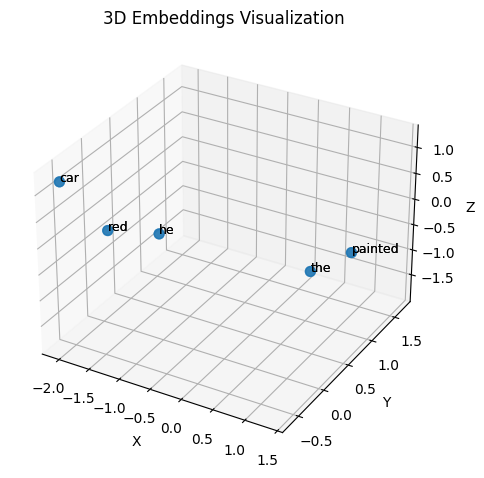

In [19]:
my_embdings = embedding(torch.tensor(my_index)).detach().numpy()
plot_embeddings(my_embdings, tokenizer(my_tokens), vocab)

In [20]:
my_embdings.shape

(10, 3)

we can effectively represent the position of each sample within a sequence by associating it with its corresponding position index, expressing the positional encoding as $p_{n}=n$, where $n$ represents the sample's position in the sequence. we can assign index 0 to the initial encoding, index 1 to the second, and so forth. This approach remains robust even when handling sequences of considerable length, extending as far as vocabulary permits.

In [21]:
position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
print(position.shape)
position

torch.Size([27, 1])


tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.]])

we can assign importance to each dimension \(d\) within the embedding, denoting it as $\textbf{p}_{n,d}$. For instance, in the case of an embedding dimension of three, the positional encodings $\textbf{p}_{n,d}$ would be represented as $[\text{ }p_{n,1},\text{ }p_{n,2},\text{ }p_{n,3}]$, which, in turn, corresponds to a three-dimensional embedding of each token.

In [22]:
d_model = 3
pe = torch.zeros(vocab_size, d_model)
pe.shape

torch.Size([27, 3])

In [23]:
pe = torch.cat((position, position, position), 1)
print(pe.shape)
pe

torch.Size([27, 3])


tensor([[ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [ 9.,  9.,  9.],
        [10., 10., 10.],
        [11., 11., 11.],
        [12., 12., 12.],
        [13., 13., 13.],
        [14., 14., 14.],
        [15., 15., 15.],
        [16., 16., 16.],
        [17., 17., 17.],
        [18., 18., 18.],
        [19., 19., 19.],
        [20., 20., 20.],
        [21., 21., 21.],
        [22., 22., 22.],
        [23., 23., 23.],
        [24., 24., 24.],
        [25., 25., 25.],
        [26., 26., 26.]])

we only need positional encodings for each sequence of embeddings, and to determine this, simply count the number of embeddings in the sequence.

In [24]:
samples, dim = my_embdings.shape
samples, dim

(10, 3)

Once we add the positional encodings to the embeddings and plot the results; you will observe that they are different.

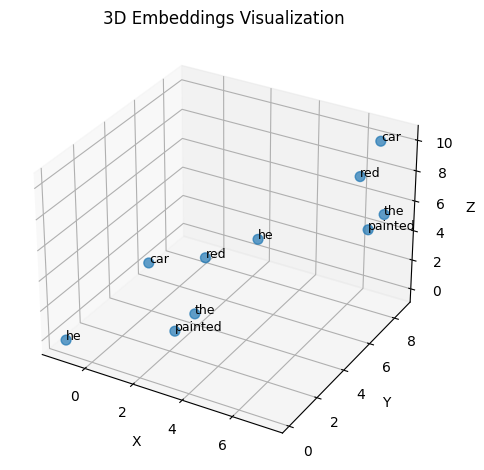

In [25]:
pos_embding = my_embdings + pe[0:samples, :].numpy()
plot_embeddings(pos_embding, tokenizer(my_tokens), vocab)

An issue arising from the integration of linear positional encodings lies in the substantial increase in the magnitude of embeddings for positions further along in the sequence. This phenomenon becomes particularly pronounced when dealing with extensive sequences. For instance, when examining the embeddings for the word "car" at indices 3 and 9, we will observe that the embedding at position 9 is notably larger. This disparity intensifies as the sequence length grows. Given that embeddings are meant to represent words, aim to avoid excessive divergence from the original embeddings.

In [26]:
pos_embding[3]

array([0.9631417, 2.3637462, 4.2024417], dtype=float32)

In [27]:
pos_embding[-1]

array([ 6.9631414,  8.363747 , 10.202442 ], dtype=float32)

we can address this magnitude issue through various approaches. Firstly, we can employ a function that doesn't exhibit such significant amplification. Additionally, we have the option to introduce different functions. For instance, when considering word positional encodings, the magnitude of the positional encodings $\textbf{p}_{n,d}$ can be represented as $[p_{n,1}, p_{n,2}, p_{n,3}]$, which, in this case, translates to $[0.1n, -0.1n, 1]$.

In [28]:
pe = torch.cat((0.1*position, -0.1*position, 0*position), 1)
pe.shape

torch.Size([27, 3])

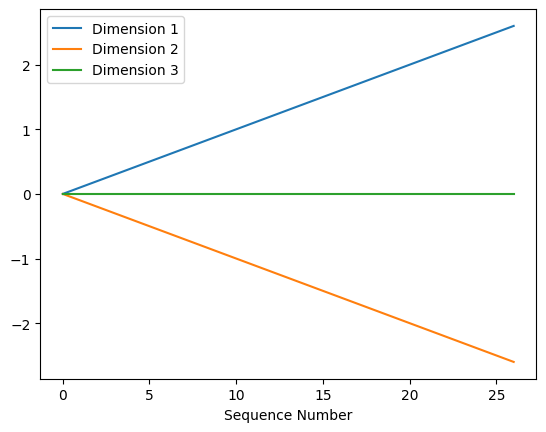

In [29]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

we will observe that the words are closer together, but employing a linear function still presents the same drawbacks.


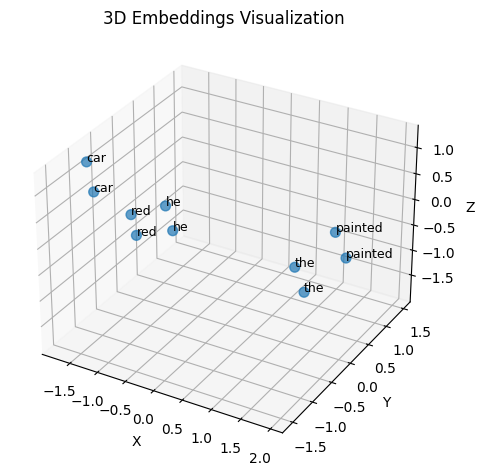

In [30]:
pos_embding = my_embdings + pe[0:samples, :].numpy()
plot_embeddings(pos_embding, tokenizer(my_tokens), vocab)

When we examine the positional encodings, we will notice that the words appear to be closer together. However, it's important to acknowledge that the use of a linear function introduces similar drawbacks. While the words may seem closer in proximity, we will still encounter certain limitations associated with linear positional encodings. These limitations include the potential for amplifying magnitudes, which can impact the model's ability to effectively capture nuanced positional information. To address these challenges, alternative approaches and functions can be explored to provide more context-aware and adaptive positional encodings.

Periodic functions, such as sine and cosine functions, possess the property of periodicity. This means they repeat their values over a regular interval, preventing them from growing too rapidly.

In [31]:
pe = torch.cat((torch.sin(2*3.14*position/6), 0*position+1, 0*position+1), 1)
pe.shape

torch.Size([27, 3])

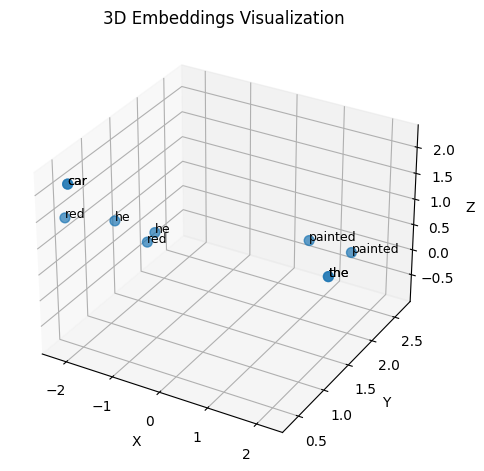

In [32]:
pos_embding = my_embdings + pe[0:samples, :].numpy()
plot_embeddings(pos_embding, tokenizer(my_tokens), vocab)

The first dimension of **$pe$** follows a sine wave pattern, while the 2nd and 3rd dimensions have constant values. This is showcased in the graph below.


In [33]:
pe

tensor([[ 0.0000,  1.0000,  1.0000],
        [ 0.8658,  1.0000,  1.0000],
        [ 0.8666,  1.0000,  1.0000],
        [ 0.0016,  1.0000,  1.0000],
        [-0.8650,  1.0000,  1.0000],
        [-0.8673,  1.0000,  1.0000],
        [-0.0032,  1.0000,  1.0000],
        [ 0.8642,  1.0000,  1.0000],
        [ 0.8681,  1.0000,  1.0000],
        [ 0.0048,  1.0000,  1.0000],
        [-0.8634,  1.0000,  1.0000],
        [-0.8689,  1.0000,  1.0000],
        [-0.0064,  1.0000,  1.0000],
        [ 0.8626,  1.0000,  1.0000],
        [ 0.8697,  1.0000,  1.0000],
        [ 0.0080,  1.0000,  1.0000],
        [-0.8617,  1.0000,  1.0000],
        [-0.8705,  1.0000,  1.0000],
        [-0.0096,  1.0000,  1.0000],
        [ 0.8609,  1.0000,  1.0000],
        [ 0.8713,  1.0000,  1.0000],
        [ 0.0111,  1.0000,  1.0000],
        [-0.8601,  1.0000,  1.0000],
        [-0.8721,  1.0000,  1.0000],
        [-0.0127,  1.0000,  1.0000],
        [ 0.8593,  1.0000,  1.0000],
        [ 0.8728,  1.0000,  1.0000]])

You have observed an intriguing characteristic in the word embeddings: they are positioned closely enough to maintain proximity while remaining sufficiently distinct from each other. However, there is a notable exception when it comes to the embedding for "car." This anomaly arises because the sine wave used in positional encoding is inherently periodic, as illustrated in the image below, where you can observe the repetitive nature of the sine function. Consequently, the positional encoding for "car" at different locations within the sequence remains the same.

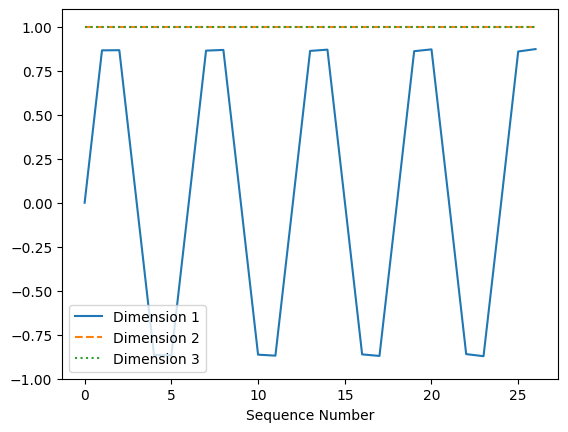

In [34]:
# Plot the positional encodings with different line styles and markers
plt.plot(pe[:, 0].numpy(), label="Dimension 1", linestyle='-')
plt.plot(pe[:, 1].numpy(), label="Dimension 2", linestyle='--')
plt.plot(pe[:, 2].numpy(), label="Dimension 3", linestyle=':')

# Adjust the y-axis scale for better visibility
plt.ylim([-1, 1.1])

plt.xlabel("Sequence Number")
plt.legend()
plt.show()

By incorporating sine and cosine functions with varying frequencies, we can effectively encode sequences of differing lengths.


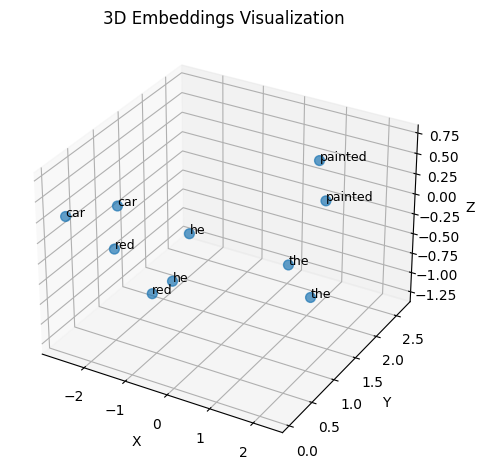

In [35]:
pe = torch.cat((torch.cos(2*3.14*position/25), torch.sin(2*3.14*position/25),  torch.sin(2*3.14*position/5)), 1)
pos_embding = my_embdings + pe[0:samples, :].numpy()
plot_embeddings(pos_embding, tokenizer(my_tokens), vocab)

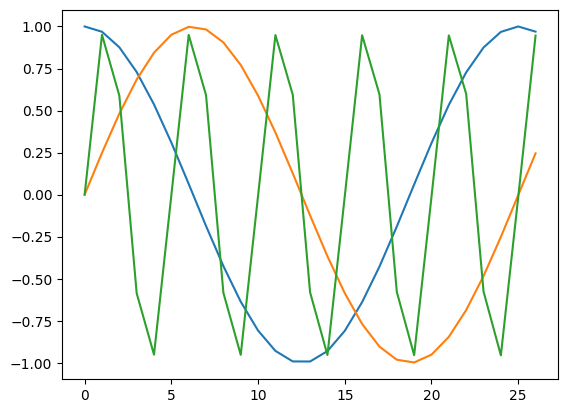

In [36]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")
plt.show()

Overall, periodic functions provide a more expressive and adaptable means of encoding positional information in sequences, making them a preferred choice in modern sequence-to-sequence models like transformers. 


## Positional Encoding Layer

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1) # [vocab_size, 1]
        div_term = torch.exp(             # [d_model/2]
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(0)    # [1, vocab_size, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):    # [batch_size, seq_len, d_model]
        # x shape: [batch_size, seq_len, d_model]
        # pe slice shape: [1, seq_len, d_model]
        # Broadcast 1 → batch_size
        # Resulting x shape: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## Encoder layer


### self-attention

Each word (or token) in a sentence is compared to every other word, including itself, to determine how much attention or importance should be assigned to each word. Three set of vectors - query, key and value are created for the tokens.


### nn.TransformerEncoderLayer

The Transformer Encoder Layer is a specialized network layer commonly used for processing sequential data. Unlike a standard linear layer, it incorporates a unique set of parameters designed to capture intricate relationships between data samples. In implementation, we can utilize `nn.TransformerEncoderLayer`.


In [38]:
my_embdings = embedding(torch.tensor(my_index))
my_embdings

tensor([[-1.1866,  0.1589, -0.1685],
        [ 1.3335,  0.8328, -0.2457],
        [ 0.0534,  1.6757, -1.8263],
        [-2.0369, -0.6363,  1.2024],
        [-1.3425, -0.5709,  0.4740],
        [-1.1866,  0.1589, -0.1685],
        [ 1.3335,  0.8328, -0.2457],
        [ 0.0534,  1.6757, -1.8263],
        [-1.3425, -0.5709,  0.4740],
        [-2.0369, -0.6363,  1.2024]], grad_fn=<EmbeddingBackward0>)

There are ten embeddings, each with three dimensions.


In [39]:
my_embdings.shape

torch.Size([10, 3])

Initializes a Transformer Encoder Layer in PyTorch using the nn.TransformerEncoderLayer class.  

- `d_model=3`: This parameter specifies the dimensionality of the model's input and output features. In this case, each input and output vector will have a size of 3. You can think of this as the "width" of the model.

- `nhead=1`: It defines the number of attention heads in the multi-head self-attention mechanism. In this case, there is only one attention head, meaning that the model will perform single-head self-attention. In the context of transformers, "n heads" refer to the number of parallel attention mechanisms used to capture diverse patterns and dependencies in the data simultaneously.

- `dim_feedforward=1`: This parameter sets the dimensionality of the feedforward neural network used within the Transformer layer. The feedforward network is responsible for processing the attention output. Here, it has an extremely low dimension of 1, which is unusually small and may not perform well in practice. In practice, this value is typically much larger to capture complex patterns.

- `dropout=0`: Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training. A dropout rate of 0 means no dropout will be applied in this layer.


In [40]:
encoder_layer = nn.TransformerEncoderLayer(
            d_model=3,
            nhead=1,
            dim_feedforward=1,
            dropout=0,
        )

In the context of transformers, our objective is to train the model to take an input sequence and effectively generate another sequence as its output, a fundamental task that underlies a wide range of natural language processing and sequence-to-sequence tasks.


In [41]:
out = encoder_layer(my_embdings)
print(out.shape)
out

torch.Size([10, 3])


tensor([[-0.9533,  1.3813, -0.4280],
        [ 0.9705,  0.4056, -1.3761],
        [ 0.3398,  1.0190, -1.3588],
        [-1.2923,  0.1488,  1.1435],
        [-1.3463,  0.2982,  1.0481],
        [-0.9533,  1.3813, -0.4280],
        [ 0.9705,  0.4056, -1.3761],
        [ 0.3398,  1.0190, -1.3588],
        [-1.3463,  0.2982,  1.0481],
        [-1.2923,  0.1488,  1.1435]], grad_fn=<NativeLayerNormBackward0>)

In the context of transformers, for tasks such as sequence classification, we aggregate these individual outputs, often by calculating their mean, resulting in a single activation value. Subsequently, standard neural network layers are employed to perform the final sequence classification.

In [42]:
_mean = out.mean(dim=1)
print(_mean.shape)
_mean

torch.Size([10])


tensor([1.0928e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0928e-07,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       grad_fn=<MeanBackward1>)

we can access the parameters of the transformer, which encompass several crucial components. Among these, the key, query, and value parameters are particularly significant, playing pivotal roles in the model's attention mechanism and overall functionality.


In [43]:
params_dict = encoder_layer.state_dict()
# Print the parameter names and shapes
for name, param in params_dict.items():
    print(name, param.shape)

self_attn.in_proj_weight torch.Size([9, 3])
self_attn.in_proj_bias torch.Size([9])
self_attn.out_proj.weight torch.Size([3, 3])
self_attn.out_proj.bias torch.Size([3])
linear1.weight torch.Size([1, 3])
linear1.bias torch.Size([1])
linear2.weight torch.Size([3, 1])
linear2.bias torch.Size([3])
norm1.weight torch.Size([3])
norm1.bias torch.Size([3])
norm2.weight torch.Size([3])
norm2.bias torch.Size([3])


The key, query, and value parameters.


In [44]:
embed_dim = 3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

In [45]:
print(q_proj_weight.shape)
print(k_proj_weight.shape)
print(v_proj_weight.shape)

torch.Size([3, 3])
torch.Size([3, 3])
torch.Size([3, 3])


## Query, key, and value 

In the context of self-attention in a transformer, we can perform the following projections:

**Query (Q)**: $Q = XW^Q$

**Key (K)**: $K = XW^K$

**Value (V)**: $V = XW^V$

Here, $X$ represents the embeddings and $W$ represents learnable weights.

In [46]:
Q = my_embdings @ q_proj_weight
K = my_embdings @ k_proj_weight
V = my_embdings @ v_proj_weight
print(Q.shape)
print(K.shape)
print(V.shape)

torch.Size([10, 3])
torch.Size([10, 3])
torch.Size([10, 3])


Attention scores:
$
   \text{Scores} = \frac{QK^T}{\sqrt{d_k}}
$


In [47]:
scores = Q @ K.T/np.sqrt(embed_dim)
print(scores.shape)
print(scores)

torch.Size([10, 10])
tensor([[ 0.2437, -0.0245,  0.6658, -0.0654,  0.0100,  0.2437, -0.0245,  0.6658,
          0.0100, -0.0654],
        [-0.5835,  0.2936, -1.2097, -0.0481, -0.1964, -0.5835,  0.2936, -1.2097,
         -0.1964, -0.0481],
        [-0.9650,  0.8261, -1.3816, -0.4374, -0.5936, -0.9650,  0.8261, -1.3816,
         -0.5936, -0.4374],
        [ 1.1318, -0.6604,  2.1366,  0.2330,  0.4663,  1.1318, -0.6604,  2.1366,
          0.4663,  0.2330],
        [ 0.6407, -0.3429,  1.2755,  0.0895,  0.2365,  0.6407, -0.3429,  1.2755,
          0.2365,  0.0895],
        [ 0.2437, -0.0245,  0.6658, -0.0654,  0.0100,  0.2437, -0.0245,  0.6658,
          0.0100, -0.0654],
        [-0.5835,  0.2936, -1.2097, -0.0481, -0.1964, -0.5835,  0.2936, -1.2097,
         -0.1964, -0.0481],
        [-0.9650,  0.8261, -1.3816, -0.4374, -0.5936, -0.9650,  0.8261, -1.3816,
         -0.5936, -0.4374],
        [ 0.6407, -0.3429,  1.2755,  0.0895,  0.2365,  0.6407, -0.3429,  1.2755,
          0.2365,  0.0895]

we can calculate the attention weights using the softmax function applied to the Scores and then multiply them by the values:

$O = \text{softmax}(\text{Scores})\cdot V$

In [48]:
nn.Softmax(dim=1)(scores).shape

torch.Size([10, 10])

In [49]:
head = nn.Softmax(dim=1)(scores) @ V
print(head.shape)
print(head)

torch.Size([10, 3])
tensor([[-0.3710,  0.2877,  0.2133],
        [-0.2302,  0.2040,  0.2236],
        [ 0.0148,  0.2647, -0.0440],
        [-0.4533,  0.3890,  0.1475],
        [-0.4324,  0.3220,  0.2152],
        [-0.3710,  0.2877,  0.2133],
        [-0.2302,  0.2040,  0.2236],
        [ 0.0148,  0.2647, -0.0440],
        [-0.4324,  0.3220,  0.2152],
        [-0.4533,  0.3890,  0.1475]], grad_fn=<MmBackward0>)


In the context of multi-head attention, we can partition the embedding dimension into $h$ subspaces, each with a dimension of $d/h$, and independently apply the attention mechanism to these smaller components. Following the attention operation, we can collect the outputs and continue with the subsequent matrix operations.

## Attention weights and linear transformation

### Softmax attention weights

After calculating the attention scores, we can proceed with linear transformations as follows:

1. **Concatenated output**: we can concatenate the individual output vectors as follows:

   $$
   O_{\text{concat}} = [O_1, O_2, \ldots, O_h]
   $$

2. **Final output**: The final output is obtained by applying a linear transformation to the concatenated output:

   $$
   O_{\text{final}} = O_{\text{concat}}W^O + b^O
   $$

Here, $W^O$ represents the weight matrix, and $b^O$ represents the bias vector for the linear transformation.


These equations depict the fundamental elements of multi-head self-attention in a transformer.  


### Multiple attention layers:
Similar to deep neural networks that can have multiple hidden layers, transformers can also be configured with multiple attention layers.

**`nn.TransformerEncoder`** is a module that represents a stack of multiple transformer encoder layers. 

**encoder_layer**: This parameter specifies the type of transformer encoder layer that we want to use within the stack. we've defined an encoder layer using `nn.TransformerEncoderLayer` with specific configurations. The encoder_layer will be repeated multiple times in the stack.

**num_layers=2**: This parameter indicates the number of encoder layers to stack on top of each other within the `nn.TransformerEncoder`. we've chosen to stack 2 encoder layers.

In [50]:
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

In [51]:
params_dict = transformer_encoder.state_dict()
for name, param in params_dict.items():
    print(name, param.shape)

layers.0.self_attn.in_proj_weight torch.Size([9, 3])
layers.0.self_attn.in_proj_bias torch.Size([9])
layers.0.self_attn.out_proj.weight torch.Size([3, 3])
layers.0.self_attn.out_proj.bias torch.Size([3])
layers.0.linear1.weight torch.Size([1, 3])
layers.0.linear1.bias torch.Size([1])
layers.0.linear2.weight torch.Size([3, 1])
layers.0.linear2.bias torch.Size([3])
layers.0.norm1.weight torch.Size([3])
layers.0.norm1.bias torch.Size([3])
layers.0.norm2.weight torch.Size([3])
layers.0.norm2.bias torch.Size([3])
layers.1.self_attn.in_proj_weight torch.Size([9, 3])
layers.1.self_attn.in_proj_bias torch.Size([9])
layers.1.self_attn.out_proj.weight torch.Size([3, 3])
layers.1.self_attn.out_proj.bias torch.Size([3])
layers.1.linear1.weight torch.Size([1, 3])
layers.1.linear1.bias torch.Size([1])
layers.1.linear2.weight torch.Size([3, 1])
layers.1.linear2.bias torch.Size([3])
layers.1.norm1.weight torch.Size([3])
layers.1.norm1.bias torch.Size([3])
layers.1.norm2.weight torch.Size([3])
layers.1

# Text classification
Text classification model using PyTorch and torchtext to classify news articles into one of the four categories: World, Sports, Business, and Sci/Tech.


### Dataset


In [131]:
# Load training data
train_df = pd.read_parquet("ag_news/train.parquet")
print("Training set shape:", train_df.shape)
display(train_df.head())

# Load test data
test_df = pd.read_parquet("ag_news/test.parquet")
print("\nTest set shape:", test_df.shape)
display(test_df.head())

Training set shape: (120000, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2



Test set shape: (7600, 2)


,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [132]:
class NewsDataset(Dataset):
    def __init__(self, df, sort_by_len=False):
        texts = df.iloc[:, 0].tolist()
        labels = df.iloc[:, 1].tolist()

        if sort_by_len:
            # sort by length of text (ascending)
            sorted_data = sorted(zip(texts, labels), key=lambda x: len(x[0]))
            texts, labels = zip(*sorted_data)

        self.texts = list(texts)
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.labels[idx], self.texts[idx]


train_dataset_full = NewsDataset(train_df, sort_by_len=True)
test_dataset = NewsDataset(test_df, sort_by_len=True)

In [133]:
len(train_dataset_full)

120000

In [134]:
len(test_dataset)

7600

In [135]:
def yield_tokens(dataset):
    for _, text in dataset:  # ignore label
        yield tokenizer(text)

In [136]:
vocab = build_vocab_from_iterator(
    yield_tokens(train_dataset_full),
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [137]:
torch.save(vocab, 'vocab.pth')
print("Vocabulary saved to vocab.pth")

Vocabulary saved to vocab.pth


In [58]:
vocab(["age", "hello"])

[2120, 12544]

In [59]:
len(vocab)

95811

In [60]:
num_train = int(len(train_dataset_full) * 0.92)
split_train_, split_valid_ = random_split(train_dataset_full, [num_train, len(train_dataset_full) - num_train])

print(f"Train samples: {len(split_train_)}")
print(f"Valid samples: {len(split_valid_)}")
print(f"Test samples:  {len(test_dataset)}")

Train samples: 110400
Valid samples: 9600
Test samples:  7600


In [61]:
for i in range(5):
    print(split_train_[i])
    print('=' * 100)

(1, 'England set to tour as ICC clear Zimbabwe England #39;s tour to Zimbabwe next month looks certain to go ahead after an inquiry found no evidence of racism within the Zimbabwe Cricket Union.')
(3, 'A Bridge Suspended in Controversy When an earthquake knocked down a section of the San Francisco-Oakland Bay Bridge, engineers vowed to make a stronger span. But years later, that plan is still mired in controversy. Part 2 of 2. By Amit Asaravala.')
(2, 'Koizumi to Bush: Strong Dollar Important (Reuters) Reuters - Japanese Prime Minister\\Junichiro Koizumi told President Bush at a bilateral meeting in\\Chile on Saturday that a strong U.S. dollar is important for\\the global economy.')
(1, 'Wenger concerned by Rooney deal LONDON, England -- Arsenal coach Arsene Wenger has voiced concerns about the deal that sent England striker Wayne Rooney from Everton to Manchester United, claiming the contract could cause a conflict of interest.')
(2, 'INTERVIEW: BA Hires Citigroup For Qantas Share Sal

In [62]:
# define class labels
ag_news_label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tec"}
classes = set([label for (label, text) in split_train_])
num_class = len(classes)
print(num_class)
print(classes)

4
{0, 1, 2, 3}


### **The code will run on the GPU**


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data loader


In [64]:
def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))


    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)
    
    return label_list.to(device), text_list.to(device)

we can convert the dataset objects to a data loader by applying the collate function.


In [65]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [66]:
for labels, texts in train_dataloader:
    print("Labels:", labels)
    print("Texts:", texts)
    break

Labels: tensor([3, 1, 0, 0, 3, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 1, 3, 0, 1, 3, 2, 3, 0,
        0, 1, 0, 1, 2, 2, 2, 3, 3, 3, 1, 2, 1, 3, 1, 2, 1, 2, 0, 0, 1, 1, 1, 2,
        0, 1, 3, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3], device='cuda:0')
Texts: tensor([[  929,  1200,  2085,  ...,     0,     0,     0],
        [ 1191,  1301, 15644,  ...,     0,     0,     0],
        [   51,     1,     9,  ...,     0,     0,     0],
        ...,
        [  432,  2530,     7,  ...,     0,     0,     0],
        [  198,  2368,   118,  ...,     0,     0,     0],
        [  766,   800,     4,  ...,     0,     0,     0]], device='cuda:0')


In [67]:
len(train_dataloader)

1725

In [68]:
# from torch.utils.data import Subset
# subset_size = 10000  # number of samples we want to use

# small_train = Subset(split_train_, range(subset_size))
# small_valid = Subset(split_valid_, range(min(subset_size, len(split_valid_))))
# small_test  = Subset(test_dataset, range(min(subset_size, len(test_dataset))))

# # Dataloaders
# train_dataloader = DataLoader(
#     small_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
# )
# valid_dataloader = DataLoader(
#     small_valid, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
# )
# test_dataloader = DataLoader(
#     small_test, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
# )

In [69]:
len(train_dataloader)

1725

### Neural network


A neural network for a text classification model using an `EmbeddingBag` layer, followed by a softmax output layer.


In [93]:
class ClassificationNet(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """
    def __init__(self, vocab_size, num_class):
        super().__init__()
        embedding_dim = 256
        nhead = 8
        dim_feedforward = 1024
        num_layers = 3
        dropout = 0.2

        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, vocab_size, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(embedding_dim, num_class)
        )
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [71]:
# emsize = 256

In [72]:
vocab_size = len(vocab)
vocab_size

95811

the number of classes for the output layer.


In [73]:
num_class

4

Creating the model:


In [74]:
model = ClassificationNet(vocab_size=vocab_size, num_class=4).to(device)
model

ClassificationNet(
  (emb): Embedding(95811, 256)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=4, bias=True)
  )
)

The code line `predicted_label=model(text, offsets)` is used to obtain predicted labels from a machine learning model for a given input text and its corresponding offsets. The `model` is the machine learning model being used for text classification or similar tasks.


In [75]:
y, x = list(train_dataloader)[0]
x.shape

torch.Size([64, 100])

In [76]:
predicted_label = model(x)

we can verify the output shape of our model. In this case, the model is trained with a mini-batch size of 64 samples. The output layer of the model produces 4 logits for each neuron, corresponding to the four classes in the classification task. we can also create a function to find the accuracy given a dataset.


In [77]:
predicted_label.shape

torch.Size([64, 4])

Function **`predict`** takes in a text and a text pipeline, which preprocesses the text for machine learning. It uses a pre-trained model to predict the label of the text for text classification on the AG_NEWS dataset. The function returns the predicted label as a result.


In [121]:
def predict(text, text_pipeline, model=model):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)), 0).to(device)
        output = model(text)
        return ag_news_label[output.argmax(1).item()]

In [123]:
predict("I like sports and stuff", text_pipeline)

'Sci/Tec'

A function to evaluate the model's accuracy on a dataset.


In [80]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [81]:
evaluate(test_dataloader, model)

0.25157894736842107

## Let's train the model.


In [82]:
LR = 0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [83]:
device

device(type='cuda')

In [86]:
# ==============================================================================
#           DEFINE HELPER FUNCTIONS FOR TRAINING AND EVALUATION
# ==============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Trains the model for one epoch.
    """
    model.train()   # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Use tqdm on the dataloader for a batch-level progress bar
    progress_bar = tqdm(dataloader, desc=f"Training")

    for labels, texts in progress_bar:
        labels, texts = labels.to(device), texts.to(device)

        # Forward pass
        predicted_labels = model(texts)
        loss = criterion(predicted_labels, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # Gradient clipping
        optimizer.step()

        # Update running loss and accuracy metrics
        running_loss += loss.item() * texts.size(0)
        _, preds = torch.max(predicted_labels, 1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += texts.size(0)

        # Update the progress bar with the current average loss
        progress_bar.set_postfix(loss=f'{running_loss/total_samples:.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()


def evaluate_epoch(model, dataloader, criterion, device):
    """
    Evaluates the model on the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc=f"Evaluating")
    
    with torch.no_grad():  # No need to track gradients during evaluation
        for labels, texts in progress_bar:
            labels, texts = labels.to(device), texts.to(device)

            predicted_labels = model(texts)
            loss = criterion(predicted_labels, labels)

            # Update metrics
            running_loss += loss.item() * texts.size(0)
            _, preds = torch.max(predicted_labels, 1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += texts.size(0)

            # Update the progress bar
            progress_bar.set_postfix(loss=f'{running_loss/total_samples:.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    return epoch_loss, epoch_acc.item()

In [87]:
# ==============================================================================
#                         THE MAIN TRAINING LOOP
# ==============================================================================

EPOCHS = 50
best_val_accuracy = 0.0

# Lists to store metrics for plotting later
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    print("-" * 50)
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # Run one training epoch
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Run validation
    val_loss, val_acc = evaluate_epoch(model, valid_dataloader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print a summary for the epoch
    print(f"\nEpoch Summary:")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tValid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")

    # Save the best model based on validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with accuracy: {best_val_accuracy*100:.2f}%")

        
print("-" * 50)
print("Training Finished!")
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}%")

# Save the metrics history
save_list_to_file(history['train_loss'], "train_loss.pkl")
save_list_to_file(history['train_acc'], "train_acc.pkl")
save_list_to_file(history['val_loss'], "val_loss.pkl")
save_list_to_file(history['val_acc'], "val_acc.pkl")


Training:   0%|          | 0/1725 [00:00<?, ?it/s]

Starting Training...
--------------------------------------------------
Epoch 1/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 130.58it/s, loss=1.0060]



Epoch Summary:
	Train Loss: 1.2368 | Train Acc: 43.64%
	Valid Loss: 1.0060 | Valid Acc: 59.27%


Training:   0%|          | 4/1725 [00:00<00:44, 38.97it/s, loss=1.0353]

New best model saved with accuracy: 59.27%
--------------------------------------------------
Epoch 2/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 125.16it/s, loss=0.9107]



Epoch Summary:
	Train Loss: 0.9234 | Train Acc: 63.06%
	Valid Loss: 0.9107 | Valid Acc: 67.09%


Training:   0%|          | 5/1725 [00:00<00:34, 49.67it/s, loss=0.8364]

New best model saved with accuracy: 67.09%
--------------------------------------------------
Epoch 3/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 123.03it/s, loss=0.8536]



Epoch Summary:
	Train Loss: 0.7939 | Train Acc: 68.98%
	Valid Loss: 0.8536 | Valid Acc: 71.12%


Training:   0%|          | 5/1725 [00:00<00:36, 47.67it/s, loss=0.7576]

New best model saved with accuracy: 71.12%
--------------------------------------------------
Epoch 4/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 125.88it/s, loss=0.7731]



Epoch Summary:
	Train Loss: 0.7207 | Train Acc: 72.54%
	Valid Loss: 0.7731 | Valid Acc: 74.17%


Training:   0%|          | 5/1725 [00:00<00:36, 47.09it/s, loss=0.6798]

New best model saved with accuracy: 74.17%
--------------------------------------------------
Epoch 5/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 127.72it/s, loss=0.7350]



Epoch Summary:
	Train Loss: 0.6722 | Train Acc: 74.78%
	Valid Loss: 0.7350 | Valid Acc: 76.07%


Training:   0%|          | 3/1725 [00:00<00:58, 29.33it/s, loss=0.5788]

New best model saved with accuracy: 76.07%
--------------------------------------------------
Epoch 6/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 105.49it/s, loss=0.7136]



Epoch Summary:
	Train Loss: 0.6377 | Train Acc: 76.43%
	Valid Loss: 0.7136 | Valid Acc: 77.28%


Training:   0%|          | 5/1725 [00:00<00:36, 46.84it/s, loss=0.6568]

New best model saved with accuracy: 77.28%
--------------------------------------------------
Epoch 7/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 100.07it/s, loss=0.6963]



Epoch Summary:
	Train Loss: 0.6147 | Train Acc: 77.35%
	Valid Loss: 0.6963 | Valid Acc: 77.84%


Training:   0%|          | 5/1725 [00:00<00:40, 42.56it/s, loss=0.6330]

New best model saved with accuracy: 77.84%
--------------------------------------------------
Epoch 8/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 103.62it/s, loss=0.6805]



Epoch Summary:
	Train Loss: 0.5968 | Train Acc: 78.20%
	Valid Loss: 0.6805 | Valid Acc: 78.50%


Training:   0%|          | 3/1725 [00:00<01:00, 28.47it/s, loss=0.5402]

New best model saved with accuracy: 78.50%
--------------------------------------------------
Epoch 9/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 81.81it/s, loss=0.6648] 



Epoch Summary:
	Train Loss: 0.5813 | Train Acc: 78.78%
	Valid Loss: 0.6648 | Valid Acc: 79.26%


Training:   0%|          | 3/1725 [00:00<01:09, 24.93it/s, loss=0.5778]

New best model saved with accuracy: 79.26%
--------------------------------------------------
Epoch 10/50


Evaluating: 100%|██████████| 150/150 [00:02<00:00, 65.86it/s, loss=0.6608]



Epoch Summary:
	Train Loss: 0.5670 | Train Acc: 79.50%
	Valid Loss: 0.6608 | Valid Acc: 79.59%


Training:   0%|          | 2/1725 [00:00<01:37, 17.72it/s, loss=0.5738]

New best model saved with accuracy: 79.59%
--------------------------------------------------
Epoch 11/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 91.91it/s, loss=0.6413]



Epoch Summary:
	Train Loss: 0.5561 | Train Acc: 79.89%
	Valid Loss: 0.6413 | Valid Acc: 80.16%


Training:   0%|          | 3/1725 [00:00<01:16, 22.48it/s, loss=0.5311]

New best model saved with accuracy: 80.16%
--------------------------------------------------
Epoch 12/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 132.30it/s, loss=0.6447]



Epoch Summary:
	Train Loss: 0.5443 | Train Acc: 80.23%
	Valid Loss: 0.6447 | Valid Acc: 80.71%


Training:   0%|          | 5/1725 [00:00<00:34, 49.24it/s, loss=0.5057]

New best model saved with accuracy: 80.71%
--------------------------------------------------
Epoch 13/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 135.84it/s, loss=0.6188]



Epoch Summary:
	Train Loss: 0.5354 | Train Acc: 80.66%
	Valid Loss: 0.6188 | Valid Acc: 80.98%


Training:   0%|          | 5/1725 [00:00<00:35, 47.92it/s, loss=0.5610]

New best model saved with accuracy: 80.98%
--------------------------------------------------
Epoch 14/50


Training:   0%|          | 4/1725 [00:00<00:49, 34.71it/s, loss=0.5455]


Epoch Summary:
	Train Loss: 0.5270 | Train Acc: 80.84%
	Valid Loss: 0.6112 | Valid Acc: 80.96%
--------------------------------------------------
Epoch 15/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 134.14it/s, loss=0.6123]



Epoch Summary:
	Train Loss: 0.5193 | Train Acc: 81.16%
	Valid Loss: 0.6123 | Valid Acc: 81.30%


Training:   0%|          | 3/1725 [00:00<01:02, 27.45it/s, loss=0.4485]

New best model saved with accuracy: 81.30%
--------------------------------------------------
Epoch 16/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 130.66it/s, loss=0.6017]



Epoch Summary:
	Train Loss: 0.5123 | Train Acc: 81.51%
	Valid Loss: 0.6017 | Valid Acc: 81.61%


Training:   0%|          | 3/1725 [00:00<01:02, 27.41it/s, loss=0.4432]

New best model saved with accuracy: 81.61%
--------------------------------------------------
Epoch 17/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 135.82it/s, loss=0.5877]



Epoch Summary:
	Train Loss: 0.5052 | Train Acc: 81.88%
	Valid Loss: 0.5877 | Valid Acc: 81.79%


Training:   0%|          | 3/1725 [00:00<01:01, 27.90it/s, loss=0.5358]

New best model saved with accuracy: 81.79%
--------------------------------------------------
Epoch 18/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 131.14it/s, loss=0.5717]



Epoch Summary:
	Train Loss: 0.5002 | Train Acc: 81.99%
	Valid Loss: 0.5717 | Valid Acc: 82.02%


Training:   0%|          | 5/1725 [00:00<00:35, 48.77it/s, loss=0.5077]

New best model saved with accuracy: 82.02%
--------------------------------------------------
Epoch 19/50


Training:   0%|          | 3/1725 [00:00<01:00, 28.37it/s, loss=0.4132]


Epoch Summary:
	Train Loss: 0.4933 | Train Acc: 82.27%
	Valid Loss: 0.5737 | Valid Acc: 81.82%
--------------------------------------------------
Epoch 20/50


Training:   0%|          | 4/1725 [00:00<00:44, 39.02it/s, loss=0.4857]


Epoch Summary:
	Train Loss: 0.4873 | Train Acc: 82.57%
	Valid Loss: 0.5789 | Valid Acc: 81.77%
--------------------------------------------------
Epoch 21/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 138.17it/s, loss=0.5690]



Epoch Summary:
	Train Loss: 0.4829 | Train Acc: 82.56%
	Valid Loss: 0.5690 | Valid Acc: 82.53%


Training:   0%|          | 5/1725 [00:00<00:41, 41.89it/s, loss=0.4931]

New best model saved with accuracy: 82.53%
--------------------------------------------------
Epoch 22/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 134.42it/s, loss=0.5618]



Epoch Summary:
	Train Loss: 0.4786 | Train Acc: 82.69%
	Valid Loss: 0.5618 | Valid Acc: 82.60%


Training:   0%|          | 4/1725 [00:00<00:46, 36.68it/s, loss=0.4113]

New best model saved with accuracy: 82.60%
--------------------------------------------------
Epoch 23/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 133.96it/s, loss=0.5593]



Epoch Summary:
	Train Loss: 0.4731 | Train Acc: 83.06%
	Valid Loss: 0.5593 | Valid Acc: 82.72%


Training:   0%|          | 3/1725 [00:00<01:05, 26.18it/s, loss=0.4250]

New best model saved with accuracy: 82.72%
--------------------------------------------------
Epoch 24/50


Training:   0%|          | 5/1725 [00:00<00:39, 43.28it/s, loss=0.4233]


Epoch Summary:
	Train Loss: 0.4699 | Train Acc: 83.09%
	Valid Loss: 0.5688 | Valid Acc: 82.53%
--------------------------------------------------
Epoch 25/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 138.60it/s, loss=0.5507]



Epoch Summary:
	Train Loss: 0.4688 | Train Acc: 83.17%
	Valid Loss: 0.5507 | Valid Acc: 82.99%


Training:   0%|          | 3/1725 [00:00<01:08, 25.05it/s, loss=0.4417]

New best model saved with accuracy: 82.99%
--------------------------------------------------
Epoch 26/50


Training:   0%|          | 6/1725 [00:00<00:35, 48.42it/s, loss=0.4591]


Epoch Summary:
	Train Loss: 0.4638 | Train Acc: 83.36%
	Valid Loss: 0.5474 | Valid Acc: 82.76%
--------------------------------------------------
Epoch 27/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 126.91it/s, loss=0.5437]



Epoch Summary:
	Train Loss: 0.4588 | Train Acc: 83.59%
	Valid Loss: 0.5437 | Valid Acc: 83.07%


Training:   0%|          | 5/1725 [00:00<00:38, 44.56it/s, loss=0.4422]

New best model saved with accuracy: 83.07%
--------------------------------------------------
Epoch 28/50


Training:   0%|          | 3/1725 [00:00<01:05, 26.41it/s, loss=0.4879]


Epoch Summary:
	Train Loss: 0.4584 | Train Acc: 83.62%
	Valid Loss: 0.5402 | Valid Acc: 83.05%
--------------------------------------------------
Epoch 29/50


Training:   0%|          | 4/1725 [00:00<00:44, 38.40it/s, loss=0.4550]


Epoch Summary:
	Train Loss: 0.4527 | Train Acc: 83.83%
	Valid Loss: 0.5416 | Valid Acc: 82.81%
--------------------------------------------------
Epoch 30/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 129.23it/s, loss=0.5402]



Epoch Summary:
	Train Loss: 0.4486 | Train Acc: 83.96%
	Valid Loss: 0.5402 | Valid Acc: 83.38%


Training:   0%|          | 4/1725 [00:00<00:45, 38.20it/s, loss=0.3820]

New best model saved with accuracy: 83.38%
--------------------------------------------------
Epoch 31/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 134.72it/s, loss=0.5228]



Epoch Summary:
	Train Loss: 0.4503 | Train Acc: 83.90%
	Valid Loss: 0.5228 | Valid Acc: 84.00%


Training:   0%|          | 5/1725 [00:00<00:36, 47.17it/s, loss=0.4282]

New best model saved with accuracy: 84.00%
--------------------------------------------------
Epoch 32/50


Training:   0%|          | 3/1725 [00:00<01:06, 25.79it/s, loss=0.5374]


Epoch Summary:
	Train Loss: 0.4451 | Train Acc: 84.04%
	Valid Loss: 0.5292 | Valid Acc: 83.81%
--------------------------------------------------
Epoch 33/50


Training:   0%|          | 3/1725 [00:00<00:59, 28.84it/s, loss=0.5614]


Epoch Summary:
	Train Loss: 0.4408 | Train Acc: 84.23%
	Valid Loss: 0.5245 | Valid Acc: 83.60%
--------------------------------------------------
Epoch 34/50


Training:   0%|          | 3/1725 [00:00<00:57, 29.96it/s, loss=0.4057]


Epoch Summary:
	Train Loss: 0.4384 | Train Acc: 84.28%
	Valid Loss: 0.5240 | Valid Acc: 83.68%
--------------------------------------------------
Epoch 35/50


Training:   0%|          | 4/1725 [00:00<00:47, 36.20it/s, loss=0.4427]


Epoch Summary:
	Train Loss: 0.4368 | Train Acc: 84.40%
	Valid Loss: 0.5205 | Valid Acc: 83.86%
--------------------------------------------------
Epoch 36/50


Training:   0%|          | 2/1725 [00:00<01:26, 19.96it/s, loss=0.5221]


Epoch Summary:
	Train Loss: 0.4335 | Train Acc: 84.45%
	Valid Loss: 0.5257 | Valid Acc: 83.77%
--------------------------------------------------
Epoch 37/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 120.89it/s, loss=0.5160]



Epoch Summary:
	Train Loss: 0.4318 | Train Acc: 84.51%
	Valid Loss: 0.5160 | Valid Acc: 84.04%


Training:   0%|          | 5/1725 [00:00<00:38, 44.55it/s, loss=0.4729]

New best model saved with accuracy: 84.04%
--------------------------------------------------
Epoch 38/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 129.79it/s, loss=0.5147]



Epoch Summary:
	Train Loss: 0.4318 | Train Acc: 84.63%
	Valid Loss: 0.5147 | Valid Acc: 84.12%


Training:   0%|          | 3/1725 [00:00<01:06, 25.88it/s, loss=0.4667]

New best model saved with accuracy: 84.12%
--------------------------------------------------
Epoch 39/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 128.72it/s, loss=0.5035]



Epoch Summary:
	Train Loss: 0.4280 | Train Acc: 84.63%
	Valid Loss: 0.5035 | Valid Acc: 84.52%


Training:   0%|          | 2/1725 [00:00<01:29, 19.35it/s, loss=0.4949]

New best model saved with accuracy: 84.52%
--------------------------------------------------
Epoch 40/50


Training:   0%|          | 2/1725 [00:00<01:26, 19.96it/s, loss=0.4329]


Epoch Summary:
	Train Loss: 0.4247 | Train Acc: 84.87%
	Valid Loss: 0.5097 | Valid Acc: 83.91%
--------------------------------------------------
Epoch 41/50


Training:   0%|          | 5/1725 [00:00<00:37, 46.16it/s, loss=0.4349]


Epoch Summary:
	Train Loss: 0.4236 | Train Acc: 84.83%
	Valid Loss: 0.5025 | Valid Acc: 84.45%
--------------------------------------------------
Epoch 42/50


Training:   0%|          | 4/1725 [00:00<00:45, 38.11it/s, loss=0.3934]


Epoch Summary:
	Train Loss: 0.4216 | Train Acc: 84.92%
	Valid Loss: 0.5045 | Valid Acc: 84.38%
--------------------------------------------------
Epoch 43/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 128.14it/s, loss=0.5026]



Epoch Summary:
	Train Loss: 0.4204 | Train Acc: 85.08%
	Valid Loss: 0.5026 | Valid Acc: 84.54%


Training:   0%|          | 4/1725 [00:00<00:48, 35.19it/s, loss=0.4515]

New best model saved with accuracy: 84.54%
--------------------------------------------------
Epoch 44/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 135.55it/s, loss=0.4928]



Epoch Summary:
	Train Loss: 0.4186 | Train Acc: 85.05%
	Valid Loss: 0.4928 | Valid Acc: 84.71%


Training:   0%|          | 4/1725 [00:00<00:49, 34.43it/s, loss=0.4041]

New best model saved with accuracy: 84.71%
--------------------------------------------------
Epoch 45/50


Training:   0%|          | 5/1725 [00:00<00:40, 42.70it/s, loss=0.4231]


Epoch Summary:
	Train Loss: 0.4144 | Train Acc: 85.31%
	Valid Loss: 0.4985 | Valid Acc: 84.55%
--------------------------------------------------
Epoch 46/50


Training:   0%|          | 5/1725 [00:00<00:36, 46.55it/s, loss=0.3915]


Epoch Summary:
	Train Loss: 0.4137 | Train Acc: 85.26%
	Valid Loss: 0.5002 | Valid Acc: 84.41%
--------------------------------------------------
Epoch 47/50


Training:   0%|          | 5/1725 [00:00<00:37, 46.37it/s, loss=0.4186]


Epoch Summary:
	Train Loss: 0.4143 | Train Acc: 85.17%
	Valid Loss: 0.4995 | Valid Acc: 84.24%
--------------------------------------------------
Epoch 48/50


Training:   0%|          | 2/1725 [00:00<01:31, 18.89it/s, loss=0.3621]


Epoch Summary:
	Train Loss: 0.4127 | Train Acc: 85.22%
	Valid Loss: 0.4941 | Valid Acc: 84.59%
--------------------------------------------------
Epoch 49/50


Training:   0%|          | 3/1725 [00:00<00:58, 29.58it/s, loss=0.4400]


Epoch Summary:
	Train Loss: 0.4096 | Train Acc: 85.37%
	Valid Loss: 0.4910 | Valid Acc: 84.67%
--------------------------------------------------
Epoch 50/50


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 132.60it/s, loss=0.5004]



Epoch Summary:
	Train Loss: 0.4087 | Train Acc: 85.37%
	Valid Loss: 0.5004 | Valid Acc: 84.66%
--------------------------------------------------
Training Finished!
Best Validation Accuracy: 84.71%


In [129]:
last_completed_epoch = 50 

checkpoint = {
    'epoch': last_completed_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'best_val_accuracy': best_val_accuracy
}

# Save the checkpoint to a file
torch.save(checkpoint, 'checkpoint_epoch_50.pth')

print(f"Checkpoint successfully saved for epoch {last_completed_epoch}.")

Checkpoint successfully saved for epoch 50.


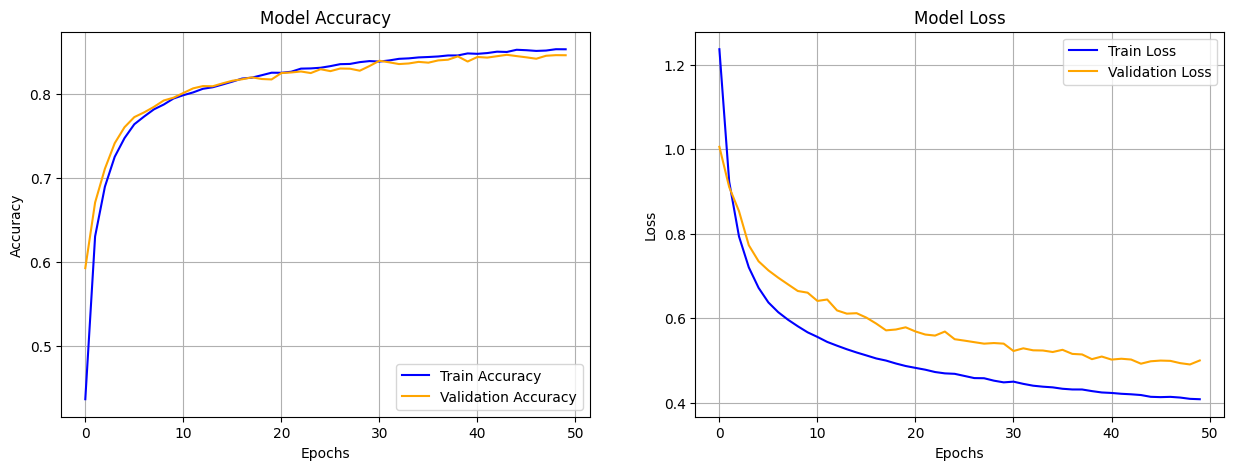

In [89]:
with open('train_loss.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open('train_acc.pkl', 'rb') as f:
    train_accuracies = pickle.load(f)

with open('val_loss.pkl', 'rb') as f:
    val_losses = pickle.load(f)
    
with open('val_acc.pkl', 'rb') as f:
    val_accuracies = pickle.load(f)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Accuracy
ax1.plot(train_accuracies, label='Train Accuracy', color='blue')
ax1.plot(val_accuracies, label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plotting Loss
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()

In [94]:
best_model = ClassificationNet(vocab_size=95811, num_class=4).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded and ready for testing.")

Best model loaded and ready for testing.


In [95]:
# ==============================================================================
#                 EVALUATE ON THE TEST DATA
# ==============================================================================

# We can reuse the same 'evaluate' function from before.
# It already sets model.eval() and uses torch.no_grad().
test_loss, test_acc = evaluate_epoch(best_model, test_dataloader, criterion, device)

Evaluating: 100%|██████████| 119/119 [00:00<00:00, 129.57it/s, loss=0.5021]


In [111]:
print("-" * 50)
print("Final Test Results:")
print(f"\tTest Loss: {test_loss:.4f}")
print(f"\tTest Accuracy: {test_acc*100:.2f}%")
print("-" * 50)

--------------------------------------------------
Final Test Results:
	Test Loss: 0.5021
	Test Accuracy: 84.36%
--------------------------------------------------


The `plot_tras` function takes input words and a transformer model as arguments. It tokenizes the input words, applies the model's embedding and positional encoding layers, and extracts projection weights for query, key, and value from the model's state_dict. Using dot-product attention, it computes and visualizes attention scores as a heatmap. The softmax of these scores is also visualized as a separate heatmap. The function calculates the attention head by multiplying softmax scores with values and employs t-SNE to visualize both the embeddings and attention heads, offering insights into the attention mechanisms within the transformer model.


In [116]:
sample = 25
words = list(train_dataset_full)[sample][1]
print(words)

Cozying up to Syria Despite Bush Administration rhetoric, the U.S. sits down with Syria's leadership


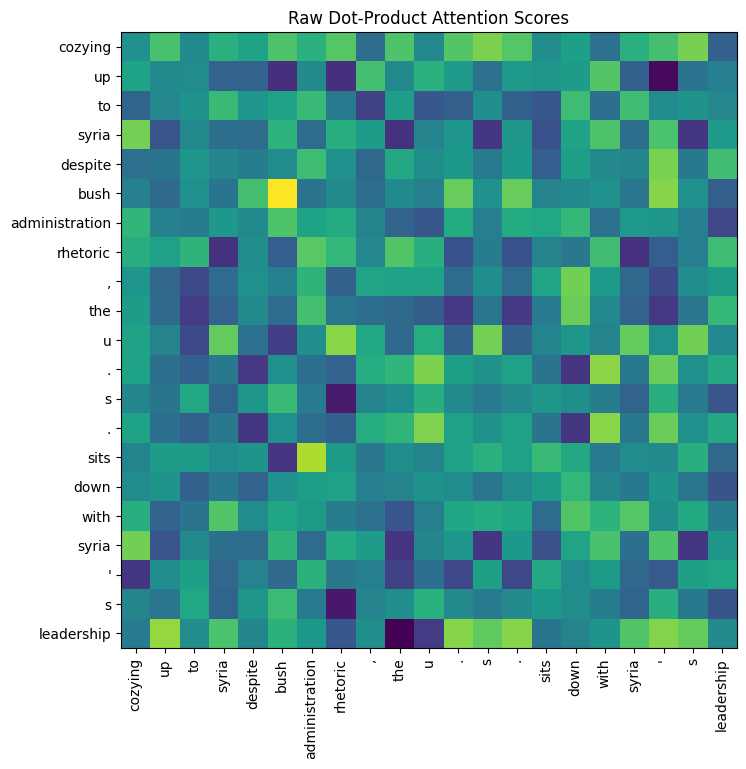

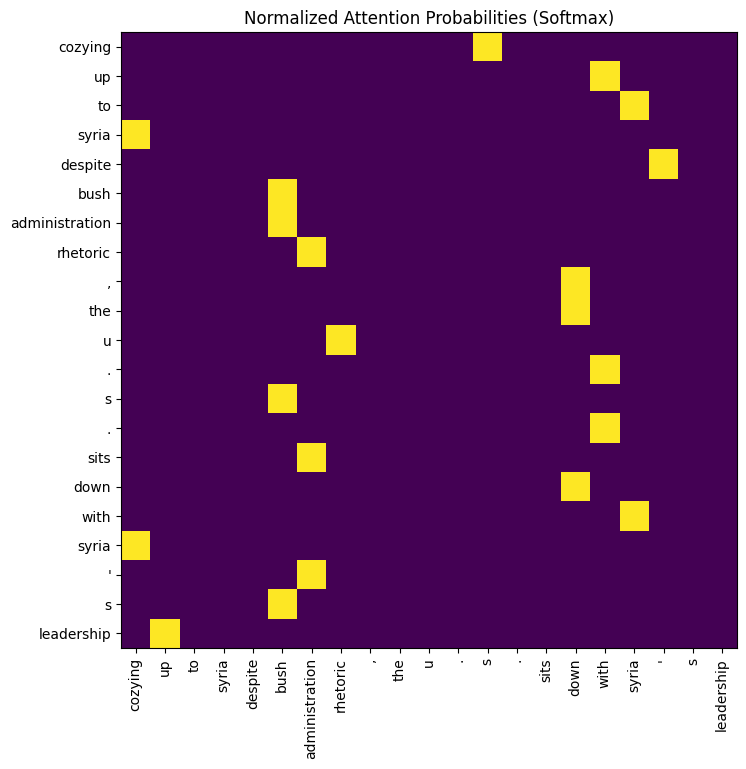

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7859f8f4d310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


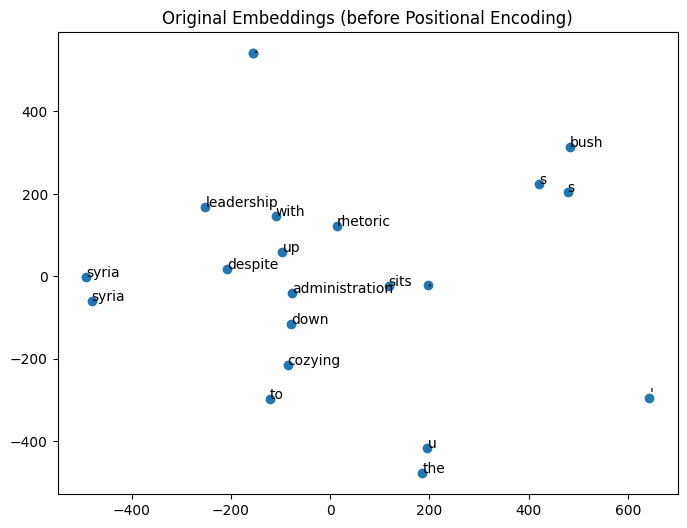

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7859f8de4160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


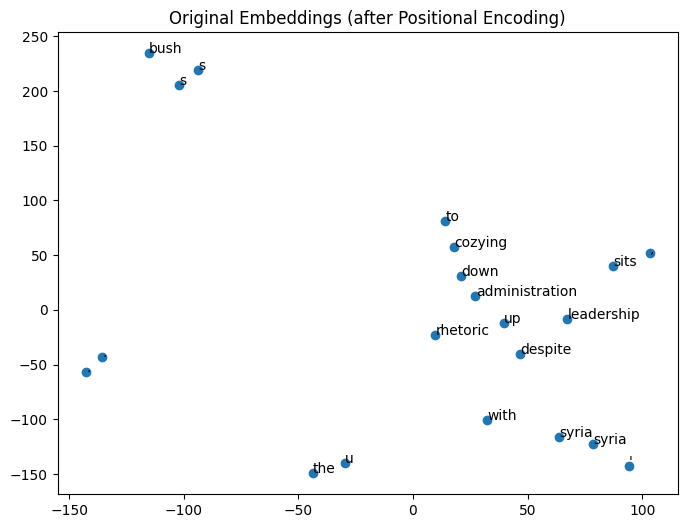

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7859f8dce1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


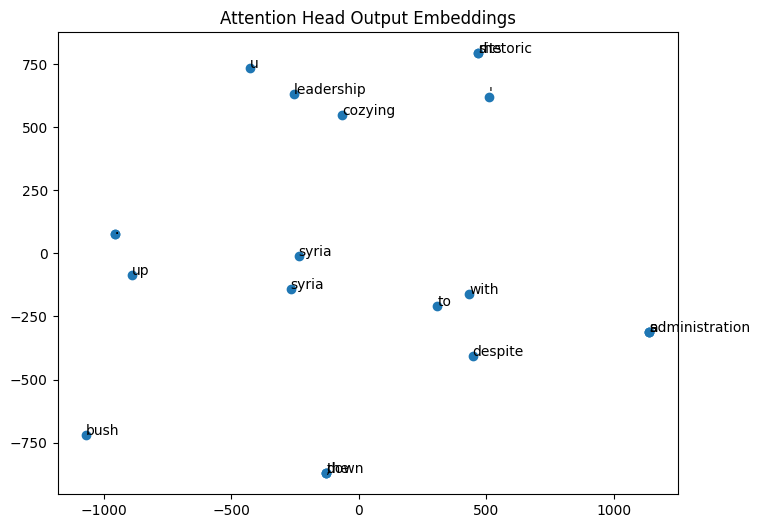

In [118]:
visualize_attention_mechanism(words, best_model, embed_dim=256)

Homebuying with Good Credit, Little Cash Will this newfangled kind of mortgage help you buy a house?


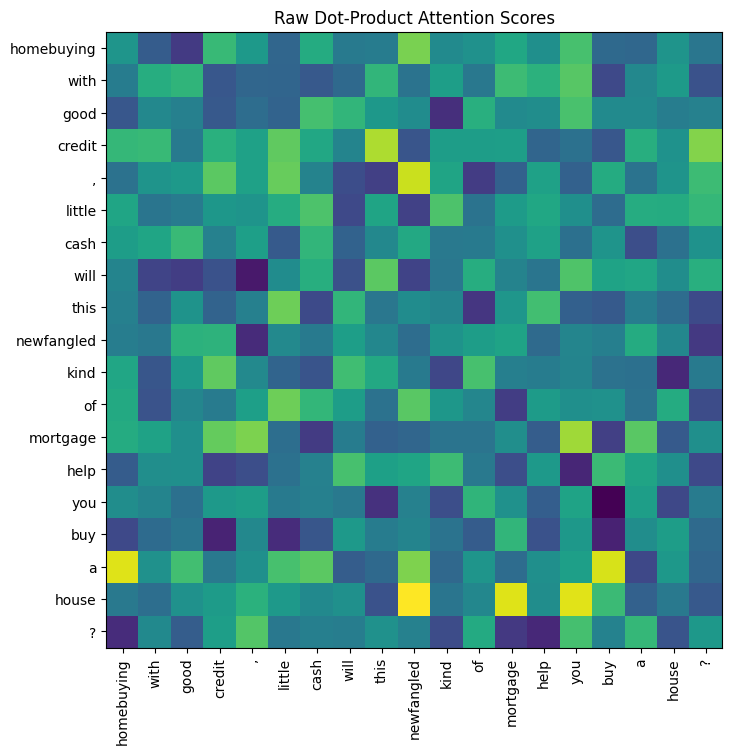

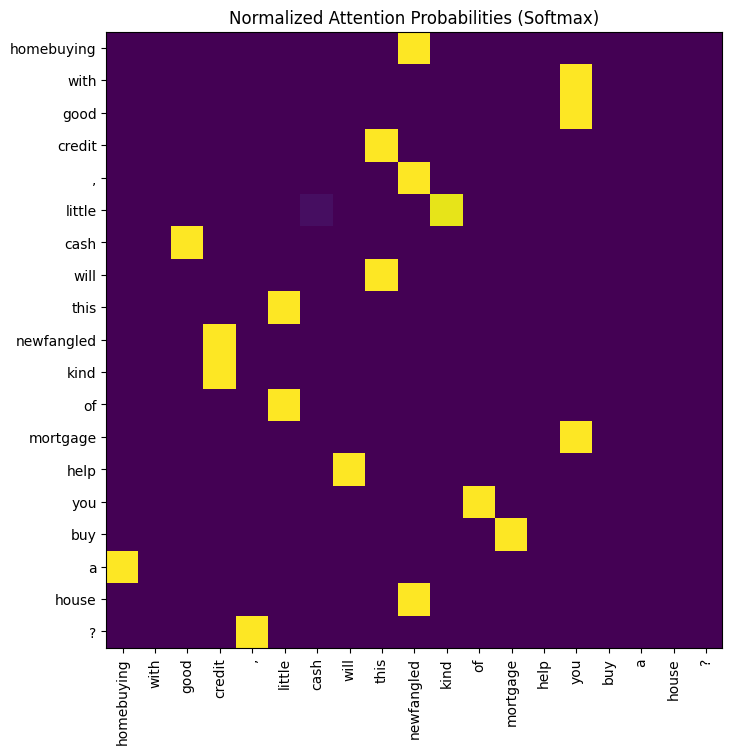

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x785b6058cdc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


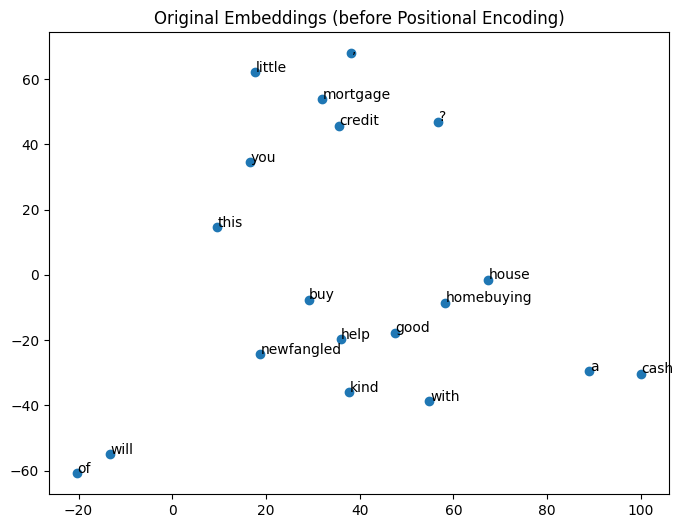

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x785b602ea040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


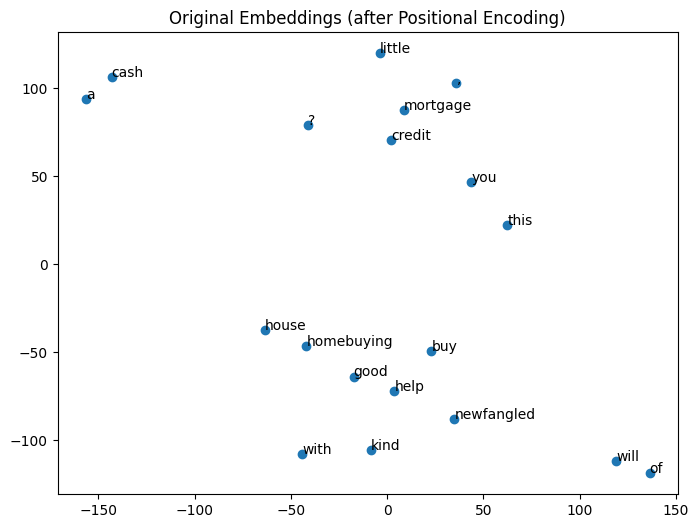

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x785b62e46160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


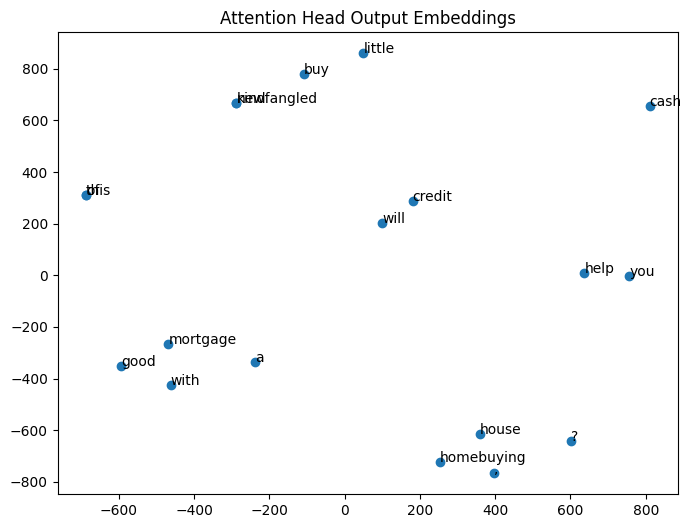

In [119]:
sample = 10
words = list(train_dataset_full)[sample][1]
print(words)
visualize_attention_mechanism(words, best_model, embed_dim=256)

## Making a prediction on the following article using the function **`predict`**.


In [120]:
article="""Canada navigated a stiff test against the Republic of Ireland on a rain soaked evening in Perth, coming from behind to claim a vital 2-1 victory at the Women’s World Cup.
Katie McCabe opened the scoring with an incredible Olimpico goal – scoring straight from a corner kick – as her corner flew straight over the despairing Canada goalkeeper Kailen Sheridan at Perth Rectangular Stadium in Australia.
Just when Ireland thought it had safely navigated itself to half time with a lead, Megan Connolly failed to get a clean connection on a clearance with the resulting contact squirming into her own net to level the score.
Minutes into the second half, Adriana Leon completed the turnaround for the Olympic champion, slotting home from the edge of the area to seal the three points."""

In [125]:
predict(article, text_pipeline, best_model)

'Sports'